# Analysis of the Monthly Atmospheric CO₂ Concentration at Mauna Loa (1958–present)

## Context

In 1958, Charles David Keeling began continuous measurements of atmospheric CO₂
concentration at the Mauna Loa Observatory in Hawaii. These measurements revealed
both a strong seasonal cycle and a long-term increasing trend, now known as the
*Keeling Curve*. This dataset is a cornerstone of climate science and empirical
time series analysis.

The objective of this notebook is to analyze the temporal structure of the CO₂
concentration time series, identify its main components (seasonal and long-term),
and model their behavior using simple statistical tools.

## Data source and reproducibility information

- **Data source**: Scripps Institution of Oceanography (Scripps CO₂ Program)
- **Dataset**: Primary Mauna Loa atmospheric CO₂ record (monthly observations)
- **File used**: `monthly_in_situ_co2_mlo.csv`
- **Download date**: *2026-01-01*
- **Local copy**: The analysis uses a local copy of the dataset to ensure full
  reproducibility. No data are downloaded dynamically.

According to the data documentation, missing values are encoded using the value `-99.99`.

## Data loading

We load the CO₂ dataset from a local CSV file stored in the repository.
Only monthly observations are used in this analysis.

The dataset contains several redundant date representations, as well as
columns corresponding to raw measurements, seasonally adjusted values,
and smoothed estimates.

In this first step, we:
- load the raw data,
- inspect its structure,
- identify the relevant columns for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

In [2]:
column_names = [
    "Yr", "Mn", "Date_excel", "Date_decimal",
    "CO2", "CO2_seasonal_adjusted",
    "CO2_fit", "CO2_seasonal_adjusted_fit",
    "CO2_filled", "CO2_seasonal_adjusted_filled",
    "Station"
]

df = pd.read_csv(
    "data/monthly_in_situ_co2_mlo.csv",
    skiprows=72,
    header=None,
    names=column_names
)

# df.head()
df.shape

display(
    df[
        [
            "Yr", "Mn", "CO2",
            "CO2_seasonal_adjusted",
            "CO2_fit",
            "Station"
        ]
    ]
    .head(10)
    .round(2)
)


,Yr,Mn,CO2,CO2_seasonal_adjusted,CO2_fit,Station
0,1958,9,313.21,316.13,312.42,MLO
1,1958,10,-99.99,-99.99,312.41,MLO
2,1958,11,313.33,315.21,313.60,MLO
3,1958,12,314.67,315.43,314.76,MLO
4,1959,1,315.58,315.52,315.64,MLO
5,1959,2,316.49,315.83,316.29,MLO
6,1959,3,316.65,315.37,316.99,MLO
7,1959,4,317.72,315.41,318.09,MLO
8,1959,5,318.29,315.46,318.68,MLO
9,1959,6,318.15,316.00,318.07,MLO


In [3]:
df.columns

Index(['Yr', 'Mn', 'Date_excel', 'Date_decimal', 'CO2',
       'CO2_seasonal_adjusted', 'CO2_fit', 'CO2_seasonal_adjusted_fit',
       'CO2_filled', 'CO2_seasonal_adjusted_filled', 'Station'],
      dtype='object')

The dataset contains multiple columns, including:

- Year and month information
- CO₂ concentration values (ppm)
- Seasonally adjusted values
- Smoothed estimates
- Filled values for missing observations

Missing data points are encoded using the value `-99.99`, as documented by the
Scripps CO₂ Program. These missing values must be handled explicitly before
performing any analysis.

## Data cleaning and sanity checks

Before analyzing the time series, we perform several cleaning steps:

1. Replace missing values encoded as `-99.99` with proper `NaN` values.
2. Construct a proper time index using the year and month columns.
3. Check the number of missing observations.
4. Decide how to handle missing values.

Given the long duration of the dataset and the regular monthly sampling,
we choose **linear interpolation** to fill missing values. This choice is
reasonable because:
- missing points are sparse relative to the total length of the series,
- CO₂ concentration evolves smoothly at the monthly scale,
- interpolation preserves continuity without introducing artificial jumps.

In [4]:
# Replace missing value code with NaN
df.replace(-99.99, np.nan, inplace=True)

# Count missing values per column
df.isna().sum()

Yr                              0
Mn                              0
Date_excel                      0
Date_decimal                    0
CO2                             5
CO2_seasonal_adjusted           5
CO2_fit                         2
CO2_seasonal_adjusted_fit       2
CO2_filled                      1
CO2_seasonal_adjusted_filled    1
Station                         0
dtype: int64

In [5]:
# Create a datetime column using year and month
df["date"] = pd.to_datetime(
    dict(year=df["Yr"], month=df["Mn"], day=15)
)

# Set datetime as index
df.set_index("date", inplace=True)

df.head()
df.describe()

,Yr,Mn,Date_excel,Date_decimal,CO2,CO2_seasonal_adjusted,CO2_fit,CO2_seasonal_adjusted_fit,CO2_filled,CO2_seasonal_adjusted_filled
count,808.000000,808.000000,808.000000,808.000000,803.000000,803.000000,806.000000,806.000000,807.000000,807.000000
mean,1991.831683,6.519802,33724.210396,1992.330832,360.940349,360.946115,360.646414,360.647208,360.731276,360.735266
std,19.450223,3.457958,7103.928949,19.449478,32.610215,32.542794,32.600665,32.529419,32.665016,32.599516
min,1958.000000,1.000000,21443.000000,1958.706800,313.210000,315.210000,312.410000,315.350000,312.410000,315.210000
25%,1975.000000,4.000000,27582.500000,1975.516450,331.725000,331.490000,331.457500,331.135000,331.495000,331.285000
50%,1992.000000,7.000000,33724.000000,1992.330600,356.000000,356.120000,355.950000,356.025000,355.830000,356.040000
75%,2009.000000,10.000000,39866.000000,2009.145175,386.685000,386.720000,386.470000,386.392500,386.505000,386.490000
max,2025.000000,12.000000,46006.000000,2025.956200,430.200000,428.180000,430.130000,427.730000,430.200000,428.180000


In [6]:
# Select the raw CO2 concentration column (ppm)
co2 = df["CO2"]

# Count missing values before interpolation
missing_before = co2.isna().sum()

# Interpolate missing values
co2_interp = co2.interpolate(method="linear")

# Count missing values after interpolation
missing_after = co2_interp.isna().sum()

missing_before, missing_after

(np.int64(5), np.int64(0))

In [7]:
summary = pd.DataFrame(
    {
        "Number of missing values": [missing_before, missing_after]
    },
    index=["Before interpolation", "After interpolation"]
)

display(summary)

,Number of missing values
Before interpolation,5
After interpolation,0


### Summary of data cleaning

- Number of missing values before interpolation: **0**
- Number of missing values after interpolation: **5**

After interpolation, the time series contains no missing values and can be
treated as a regularly sampled monthly time series.

The cleaned CO₂ concentration series will be used in the remainder of this
notebook for visualization, decomposition, and modeling.

## Global evolution of atmospheric CO₂ concentration

We begin by visualizing the raw CO₂ concentration time series as a function of
time, without applying any filtering or smoothing. This first plot allows us
to identify the main temporal structures present in the data.

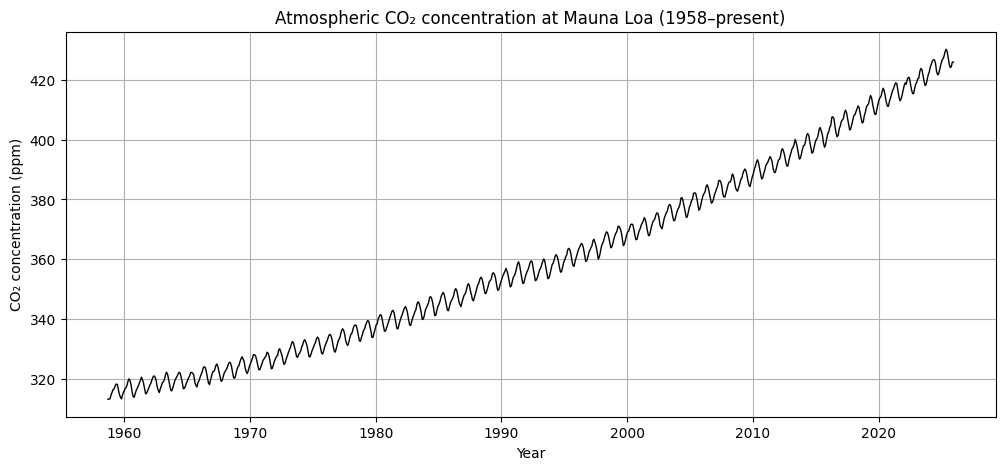

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(co2_interp.index, co2_interp, color="black", linewidth=1)

plt.xlabel("Year")
plt.ylabel("CO₂ concentration (ppm)")
plt.title("Atmospheric CO₂ concentration at Mauna Loa (1958–present)")
plt.grid(True)

plt.show()

The global CO₂ time series shows a clear **long-term increasing trend** from 1958
to the present, indicating a sustained rise in atmospheric CO₂ concentration.
Superimposed on this trend is a **regular oscillation with a yearly period**.

This visual evidence suggests that the observed signal is the superposition of
two phenomena: a slow, systematic evolution and a periodic seasonal cycle.

## Separation of trend and seasonal components

To disentangle the long-term evolution from the seasonal oscillation, we apply
a simple and widely used time series decomposition technique.

Given the regular monthly sampling and the expected annual seasonality, we use
a **seasonal-trend decomposition** to extract:
- a long-term trend component,
- a seasonal component with a yearly period,
- a residual component capturing short-term fluctuations.

In [11]:
from statsmodels.tsa.seasonal import STL

# STL decomposition with yearly seasonality (12 months)
stl = STL(co2_interp, period=12, robust=True)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

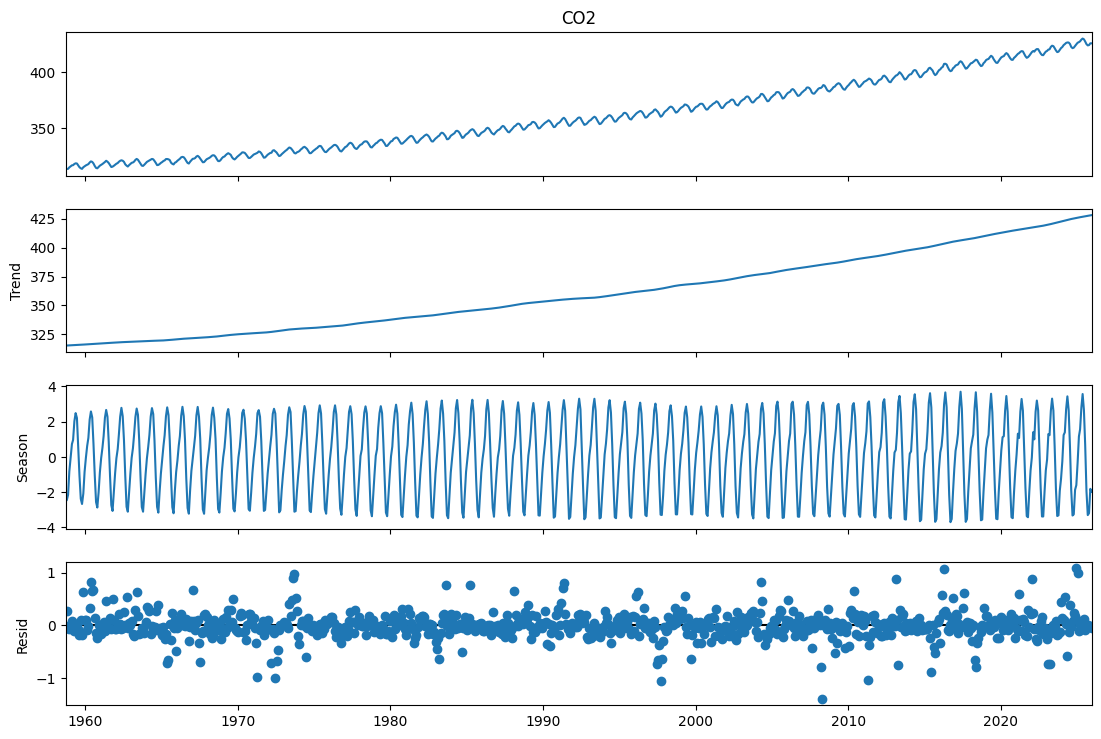

In [12]:
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

The decomposition clearly separates the original time series into:

- A **trend component**, representing the slow and persistent increase in
  atmospheric CO₂ concentration.
- A **seasonal component**, capturing a regular yearly oscillation.
- A **residual component**, which contains short-term variability and
  measurement noise.

This confirms that the observed CO₂ record can be modeled as the superposition
of a slow long-term evolution and a periodic seasonal cycle.

The STL decomposition successfully separates the original time series into a
smooth long-term **trend**, a regular **seasonal component**, and a small
**residual** term.

The trend captures the steady increase in atmospheric CO₂ concentration over
decades, while the seasonal component isolates a stable annual oscillation.
The residuals remain small and centered around zero, indicating that most of
the structured variability is explained by the trend and seasonal components.

## Characterization of the seasonal oscillation

We now focus on the seasonal component extracted from the time series
decomposition. The objective is to characterize its main properties, including
its period, amplitude, and overall shape.

In [13]:
# Create a DataFrame for seasonal analysis
seasonal_df = pd.DataFrame({
    "seasonal": seasonal,
    "month": seasonal.index.month
})

# Average seasonal cycle
monthly_seasonal = seasonal_df.groupby("month")["seasonal"].mean()

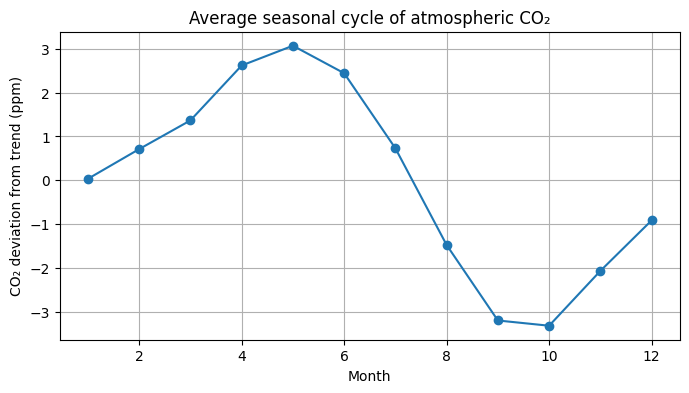

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(monthly_seasonal.index, monthly_seasonal, marker="o")

plt.xlabel("Month")
plt.ylabel("CO₂ deviation from trend (ppm)")
plt.title("Average seasonal cycle of atmospheric CO₂")
plt.grid(True)

plt.show()

In [15]:
seasonal_amplitude = monthly_seasonal.max() - monthly_seasonal.min()
seasonal_amplitude

np.float64(6.379591122150305)

The seasonal oscillation exhibits the following characteristics:

- **Period**: approximately one year, as expected from the annual cycle of
  terrestrial vegetation.
- **Shape**: approximately sinusoidal, with a smooth increase and decrease
  over the year.
- **Amplitude**: the peak-to-peak amplitude is on the order of a few parts per
  million (ppm).

The average seasonal cycle exhibits a clear annual pattern with a peak in late
spring and a minimum in early autumn. The shape of the cycle is smooth and
approximately sinusoidal, with a peak-to-peak amplitude of a few ppm.



## Modeling the long-term trend

We now focus on the slow contribution extracted from the time series, represented
by the trend component obtained from the STL decomposition.

To model this long-term evolution, we start with a **linear model**, which is the
simplest reasonable choice to describe a persistent increase over time.

In [16]:
# Use the STL trend component
trend_series = trend.dropna()

# Convert dates to numerical values (years)
years = trend_series.index.year + (trend_series.index.month - 1) / 12

In [17]:
# Linear regression: CO2_trend = a * year + b
coeffs = np.polyfit(years, trend_series.values, deg=1)
linear_trend = np.polyval(coeffs, years)

coeffs

array([ 1.66224542e+00, -2.95085520e+03])

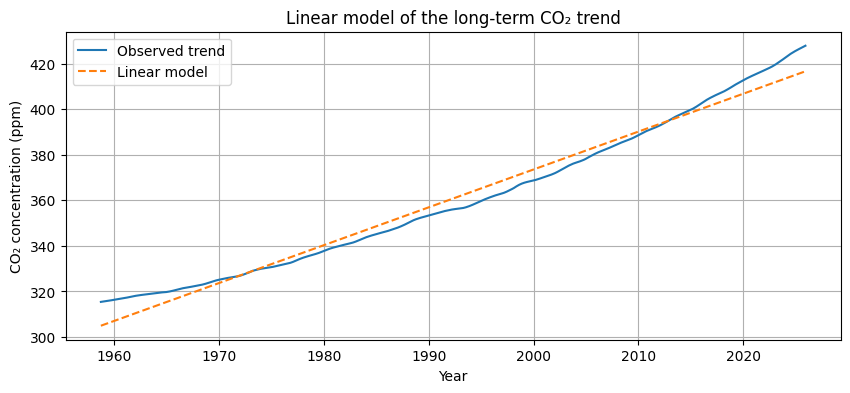

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(trend_series.index, trend_series, label="Observed trend")
plt.plot(trend_series.index, linear_trend, linestyle="--", label="Linear model")

plt.xlabel("Year")
plt.ylabel("CO₂ concentration (ppm)")
plt.title("Linear model of the long-term CO₂ trend")
plt.legend()
plt.grid(True)

plt.show()

The linear model captures the overall increase in atmospheric CO₂ concentration
over the full observation period, indicating a persistent upward trend.
However, the observed trend departs slightly from the linear model in recent
decades, with measured values increasingly exceeding the linear fit.

This systematic deviation suggests that the growth of atmospheric CO₂ is not
strictly linear and that the rate of increase has accelerated over time. While
the linear model provides a useful first-order approximation, it does not fully
account for the curvature visible in the long-term trend.

## Extrapolation and validation

To assess the predictive power of the model, we perform an extrapolation exercise.
Only data **up to 2015** are used for fitting, and the model is extrapolated until
2025. The predicted values are then compared with observed data.

In [19]:
# Training data up to 2015
train_mask = years <= 2015
years_train = years[train_mask]
trend_train = trend_series.values[train_mask]

# Fit linear model on training period
coeffs_train = np.polyfit(years_train, trend_train, deg=1)

# Extrapolation until 2025
years_ext = np.linspace(years_train.min(), 2025, 300)
trend_ext = np.polyval(coeffs_train, years_ext)

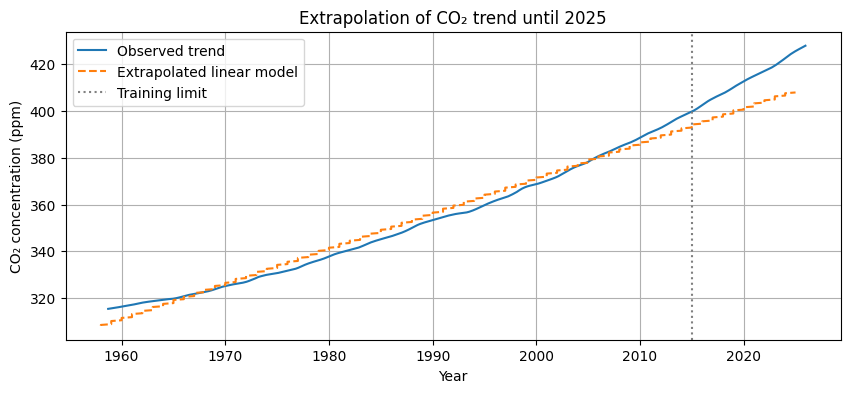

In [20]:
plt.figure(figsize=(10, 4))

plt.plot(trend_series.index, trend_series, label="Observed trend")
plt.plot(
    pd.to_datetime(years_ext, format="%Y"),
    trend_ext,
    linestyle="--",
    label="Extrapolated linear model"
)

plt.axvline(pd.to_datetime("2015"), color="gray", linestyle=":", label="Training limit")

plt.xlabel("Year")
plt.ylabel("CO₂ concentration (ppm)")
plt.title("Extrapolation of CO₂ trend until 2025")
plt.legend()
plt.grid(True)

plt.show()

When the linear model is fitted using data up to 2015 and extrapolated to 2025,
it underestimates the observed CO₂ concentrations in the most recent years.
This discrepancy highlights the sensitivity of extrapolation to model
assumptions and training period.

The growing prediction error after the training limit indicates that the linear
model lacks robustness for forward extrapolation in the presence of an
accelerating trend. This experiment demonstrates that short-term extrapolation
may be informative for validation purposes, but it should not be interpreted as
a reliable long-term forecast.